# 4 Predictive Analytics
Future demand is a key factor that will steer operational decision making of a shared rental network. As a data scientist it is your responsibility to facilitate this type of decision support. For the purpose of this assignment we will be interested in **forecasting total system-level demand in the next hour**. To do so, develop a prediction model that **predicts bike rental demand as a function of suitable features available in or derived from the datasets (incl. the weather data).**

1. Feature Engineering: **Develop a rich set of features that you expect to be correlated with your target**. In this process you can draw on your domain knowledge and/or conduct additional research around the topic of demand prediction in vehicle rental networks. Justify your selection of features.

2. Model Building: Select **three regression algorithms** that are suitable for the prediction task at hand. **Explain and justify** why you selected the three algorithms and describe their respective advantages and drawbacks.

3. Model Evaluation: **How well do the models perform? Evaluate and benchmark your models’ performance using suitable evaluation metrics. Which model would you select for deployment?**

4. Outlook: How could the selected model be improved further? Explain some of the improvement levers that you might focus on in a follow-up project.

Notes and tipps

- Make generous use of visualization techniques to clearly illustrate your findings and present them in an appealing fashion.
- Evaluate your methodology and clearly state why you have opted for a specific approach in your analysis.
- Relate your findings to the real world and interpret them for non-technical audiences (e.g. What do the coefficients in your regression model mean?, What does the achieved error mean for your model?, etc.)
- Make sure to clearly state the implications (i.e. the ”so what?”) of your findings for managers/decision makers.

## 4.1 Import

In [126]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
import statistics
import timeit
import time


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor

import random
random.seed(42)

%matplotlib inline

In [55]:
import warnings
warnings.filterwarnings("ignore")

**Import of data**

In [2]:
df_trips = pd.read_csv('data/boston_2017_cleaned_trips.csv')
df_weather = pd.read_csv('data/weather_2017_cleaned.csv')

In [61]:
df_trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1310760 entries, 0 to 1310759
Data columns (total 12 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   start_time          1310760 non-null  object 
 1   end_time            1310760 non-null  object 
 2   start_station_id    1310760 non-null  int64  
 3   end_station_id      1310760 non-null  int64  
 4   start_station_name  1310760 non-null  object 
 5   end_station_name    1310760 non-null  object 
 6   bike_id             1310760 non-null  int64  
 7   user_type           1310760 non-null  object 
 8   start_hour          1310760 non-null  int64  
 9   weekday             1310760 non-null  int64  
 10  duration            1310760 non-null  float64
 11  month               1310760 non-null  int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 120.0+ MB


Our pre-processed data already contains various information about the temporal patterns e.g. the start time furthermore the hour, weekday and month of the trips.

In [62]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   max_temp   8760 non-null   float64
 1   min_temp   8760 non-null   float64
 2   precip     8760 non-null   float64
 3   date_time  8760 non-null   object 
dtypes: float64(3), object(1)
memory usage: 273.9+ KB


Setting the start time as the DateTimeIndex for our dataframe.

In [3]:
df_trips['start_date'] = df_trips['start_time']
df_trips.set_index('start_date', inplace = True)
df_trips.index = pd.to_datetime(df_trips.index)

## 4.2 Feature Engineering

In advance of building the models, suitable variables are engineered to improve prediction performance. 

In [4]:
# calculating the total amount of trips started per hour
df_trips['start_time'] = pd.to_datetime(df_trips['start_time'])
df_trips_group = df_trips.groupby(pd.Grouper(key='start_time', freq='H')).count()
hourly_demand = df_trips_group['end_time']
hourly_demand

Creating the dataset with the grouped demand

In [19]:
df_weather['date_time'] = pd.to_datetime(df_weather['date_time'])
df_weather.set_index('date_time', inplace = True)

df_pred_feat = df_weather
df_pred_feat["hourly_demand"] = hourly_demand

In [20]:
# adding basic temporal features
df_pred_feat["hour"] = df_pred_feat.index.hour
df_pred_feat["weekday"] = df_pred_feat.index.weekday
df_pred_feat["month"] = df_pred_feat.index.month

In [21]:
df_pred_feat.groupby('hour').sum()["hourly_demand"]
#df_pred_feat.groupby('month').sum()["hourly_demand"]

hour
0       9866
1       6327
2       3937
3       1564
4       1806
5       7128
6      25965
7      72051
8     124150
9      75123
10     55609
11     61137
12     72006
13     71305
14     70861
15     78777
16    113096
17    147961
18    108039
19     73514
20     50700
21     35688
22     26777
23     17373
Name: hourly_demand, dtype: int64

After calculating the hourly demand it probably makes sense to categorzie each hour into two separate groups:
* Peak hours between 7 am and 9 am
* Peak hours between 12 am and 7 pm

In [22]:
# advances temporal features and dummy encoding
df_pred_feat['is_workday'] = df_pred_feat['weekday'].apply(lambda x: 1 if x < 5 else 0)
df_pred_feat['peak_hour_1'] = df_pred_feat['hour'].apply(lambda x: 1 if x > 6 & x < 10 else 0)
df_pred_feat['peak_hour_2'] = df_pred_feat['hour'].apply(lambda x: 1 if x > 11 & x < 20 else 0)

# calculating the quarters to represent seasonality in our data 
df_pred_feat['quarter'] = df_pred_feat['month'].apply(lambda x: x // 4)
df_pred_feat = pd.get_dummies(df_pred_feat, columns = ['quarter'])

As hour and weekday are cyclical features the sin and cos components are calculated to preserve information such as hour 23 and hour 0 being close to each other and not far.

In [23]:
df_pred_feat['hour_sin'] = np.sin(df_pred_feat.hour*(2.*np.pi/24))
df_pred_feat['hour_cos'] = np.cos(df_pred_feat.hour*(2.*np.pi/24))
# month values between 0 and 11 
df_pred_feat['month_sin'] = np.sin((df_pred_feat.month-1)*(2.*np.pi/12))
df_pred_feat['month_cos'] = np.cos((df_pred_feat.month-1)*(2.*np.pi/12))

In [24]:
# scale temperature features 
mean_temp = statistics.mean(df_pred_feat['max_temp'])
std_temp = statistics.stdev(df_pred_feat['max_temp'])
df_pred_feat['temp_scaled'] = (df_pred_feat['max_temp'] - mean_temp) / std_temp

In [25]:
# For simplification we remove the features "max_temp" and "min_temp"
df_pred_feat = df_pred_feat.drop(columns=['max_temp','min_temp'])
df_pred_feat

,precip,hourly_demand,hour,weekday,month,is_workday,peak_hour_1,peak_hour_2,quarter_0,quarter_1,quarter_2,quarter_3,hour_sin,hour_cos,month_sin,month_cos,temp_scaled
date_time,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,0.0,13,0,6,1,0,0,0,1,0,0,0,0.000000,1.000000,0.0,1.000000,-0.752447
2017-01-01 01:00:00,0.0,7,1,6,1,0,1,0,1,0,0,0,0.258819,0.965926,0.0,1.000000,-0.702026
2017-01-01 02:00:00,1.0,4,2,6,1,0,0,0,1,0,0,0,0.500000,0.866025,0.0,1.000000,-0.641519
2017-01-01 03:00:00,1.0,2,3,6,1,0,1,0,1,0,0,0,0.707107,0.707107,0.0,1.000000,-0.641519
2017-01-01 04:00:00,1.0,6,4,6,1,0,0,1,1,0,0,0,0.866025,0.500000,0.0,1.000000,-0.641519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 19:00:00,0.0,6,19,6,12,0,1,1,0,0,0,1,-0.965926,0.258819,-0.5,0.866025,-2.265101
2017-12-31 20:00:00,0.0,5,20,6,12,0,1,1,0,0,0,1,-0.866025,0.500000,-0.5,0.866025,-2.214679
2017-12-31 21:00:00,0.0,3,21,6,12,0,1,1,0,0,0,1,-0.707107,0.707107,-0.5,0.866025,-2.265101


**Evaluating Feature Correlation**

The heatmap shows the correlation between the features. Even though only features which have a stronger correlation to the demand per hour seem important, in the upcoming model evaluation different sets of features will be evaluated against each other so the perfect features for each model will be used.

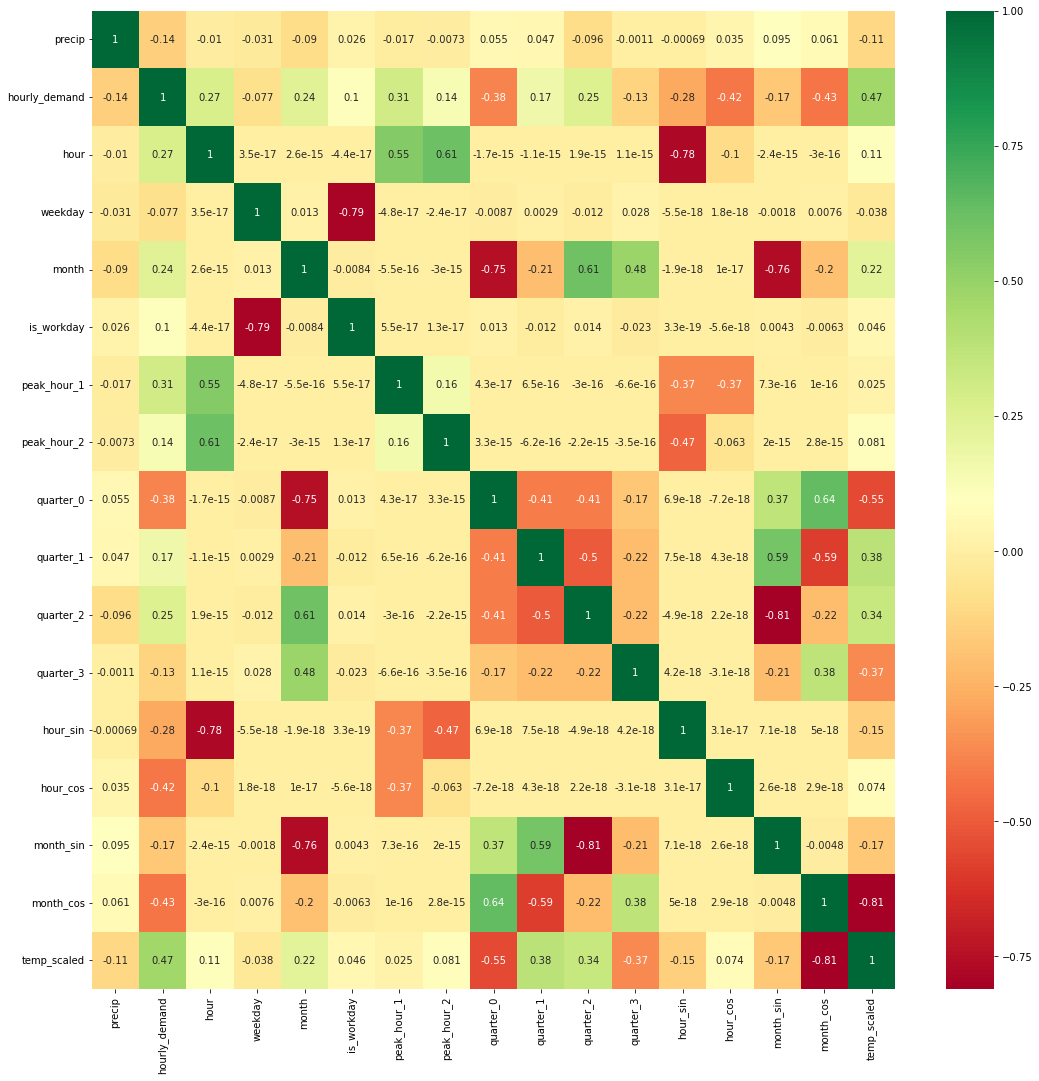

In [26]:
corrmat = df_pred_feat.corr()
top_corr_features = corrmat.index

plt.figure(figsize=(18,18))

g=sns.heatmap(df_pred_feat[top_corr_features].corr(),annot=True, cmap="RdYlGn")

## 4.3 Model Building

TBD

Now the prediction models can be created. The 3 chosen Regression Models are: 

- Ridge Regression based on linear multipolinomial Regression
- Decision Tree
- XGBoost Regression

The three algorithms were chosen as they are different approaches to the prediction problem with increasing complexity. 
While the ridge regression is mostly implemented in this notebook, the decision tree and xgboost model are taken from packages.

- Decision tree + : easy to understand explainable ML 
- XGBoost good performance but blackbox 

TBD: Why did we chose these models + advantages and drawbacks


Let's start with our basic features.

In [38]:
# feature_set = [['precip', 'weekday', 'month_cos', 'is_workday', 'quarter_0', 'hour_sin', 'hour_cos', 'temp_scaled']]
feature_set = [['hour', 'weekday', 'month', 'temp_scaled', 'precip']]

In [74]:
X_train, y_train, X_test, y_test = data_split(feature_set[0])

### 4.3.1 Decision Tree Regressor

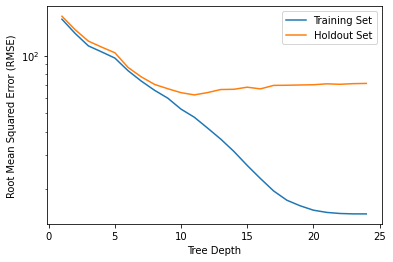

In [31]:
err_train = []
err_test = []
r_2_score = []

for i in range(1, 25):
    # Fit regression model
    regr = DecisionTreeRegressor(max_depth=i)
    regr.fit(X_train, y_train)

    # Predict
    train_pred = regr.predict(X_train)
    test_pred = regr.predict(X_test)

#   Calculate training and cross validation error, method = Root Mean Squared Error
    err_train.append(mean_squared_error(y_train, train_pred, squared = False))
    err_test.append(mean_squared_error(y_test, test_pred, squared = False))
    r_2_score.append(r2_score(y_test, test_pred))
    
    
# Plotting the training and test error
plt.semilogy(range(1,25),err_train, range(1, 25),err_test)
plt.xlabel('Tree Depth')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.legend(['Training Set', 'Holdout Set'])
plt.show()

[0.8171553407338226, 0.8474807353290843, 0.8625346388570841, 0.8750035523186037, 0.8815881128378009, 0.8748462208819122]


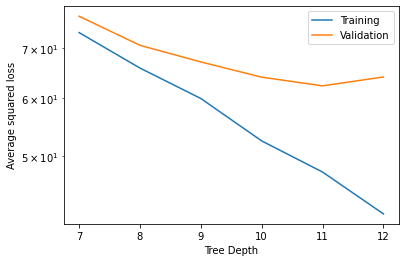

In [32]:
dep = np.arange(1, 25)

plt.semilogy(dep[6:12], err_train[6:12], dep[6:12], err_test[6:12])
plt.legend(["Training", "Validation"])
plt.xlabel("Tree Depth")
plt.ylabel("Average squared loss")

print(r_2_score[6:12]) 
# TODO Funktion schreiben, die den Index des besten R^2 Score zurückgibt

### 4.3.2 Linear Regression (L2-Regression)

In [33]:
# lin_reg_features = [['precip', 'weekday', 'month', 'is_workday', 'quarter_0', 'hour_sin', 'hour_cos', 'temp_scaled']]

In [34]:
# X_train, y_train, X_test, y_test = data_split(lin_reg_features[0])
# X_train

,precip,weekday,month,is_workday,quarter_0,hour_sin,hour_cos,temp_scaled
date_time,,,,,,,,
2017-03-02 04:00:00,0.0,3,3,1,1,0.866025,0.500000,0.538351
2017-03-10 20:00:00,1.0,4,3,1,1,-0.866025,0.500000,-1.256665
2017-11-09 08:00:00,0.0,3,11,1,0,0.866025,-0.500000,-1.034809
2017-03-20 21:00:00,0.0,0,3,1,1,-0.707107,0.707107,-0.076795
2017-06-11 16:00:00,0.0,6,6,0,0,-0.866025,-0.500000,1.940076
...,...,...,...,...,...,...,...,...
2017-08-27 22:00:00,0.0,6,8,0,0,-0.500000,0.866025,0.760206
2017-08-05 07:00:00,0.0,5,8,0,0,0.965926,-0.258819,0.982062
2017-08-13 14:00:00,0.0,6,8,0,0,-0.500000,-0.866025,1.546786


/Users/hannesvogelsang/opt/anaconda3/envs/AA/lib/python3.10/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
/Users/hannesvogelsang/opt/anaconda3/envs/AA/lib/python3.10/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a prepro

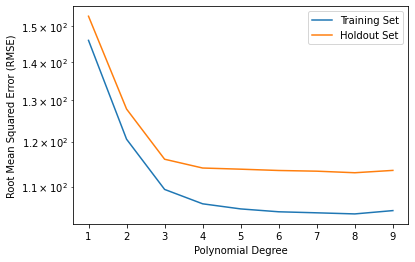

[0.2855541384455831, 0.5014060588700847, 0.5895695489211756, 0.6033244044182766, 0.6051026361935603, 0.6070918363898723, 0.6081479859172341, 0.6105070689009658, 0.6069536590575986]


In [40]:
# Hyperparameter Tuning for Ridge Regression (L2-Regression)

err_train = []
err_test = []
r_2_score = []

for i in range(1, 10):
    
    poly_reg = PolynomialFeatures (degree = i)
    x_poly = poly_reg.fit_transform(X_train)

    model = Ridge(alpha = 0, normalize = True, solver = 'lsqr')
    model.fit(x_poly, y_train)

    train_pred = model.predict(x_poly)
    test_pred = model.predict(poly_reg.fit_transform(X_test))
    
#   Calculate training and cross validation error, method = Root Mean Squared Error
    err_train.append(mean_squared_error(y_train, train_pred, squared = False))
    err_test.append(mean_squared_error(y_test, test_pred, squared = False))
    r_2_score.append(r2_score(y_test, test_pred))
    
    
# Plotting the training and test error
plt.semilogy(range(1,10),err_train, range(1, 10),err_test)
plt.xlabel('Polynomial Degree')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.legend(['Training Set', 'Holdout Set'])
plt.show()
print(r_2_score)

In [ ]:
# WIE KANN DAS SEIN, DASS Lambda = 0 zu höheren Polynomen führen kann???
# Eigentlich ist das die normale Regression OHNE Regularization

/Users/hannesvogelsang/opt/anaconda3/envs/AA/lib/python3.10/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
/Users/hannesvogelsang/opt/anaconda3/envs/AA/lib/python3.10/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a prepro

/Users/hannesvogelsang/opt/anaconda3/envs/AA/lib/python3.10/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
/Users/hannesvogelsang/opt/anaconda3/envs/AA/lib/python3.10/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a prepro

/Users/hannesvogelsang/opt/anaconda3/envs/AA/lib/python3.10/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
/Users/hannesvogelsang/opt/anaconda3/envs/AA/lib/python3.10/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a prepro

/Users/hannesvogelsang/opt/anaconda3/envs/AA/lib/python3.10/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
/Users/hannesvogelsang/opt/anaconda3/envs/AA/lib/python3.10/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a prepro

/Users/hannesvogelsang/opt/anaconda3/envs/AA/lib/python3.10/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
/Users/hannesvogelsang/opt/anaconda3/envs/AA/lib/python3.10/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a prepro

/Users/hannesvogelsang/opt/anaconda3/envs/AA/lib/python3.10/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
/Users/hannesvogelsang/opt/anaconda3/envs/AA/lib/python3.10/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a prepro

/Users/hannesvogelsang/opt/anaconda3/envs/AA/lib/python3.10/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
/Users/hannesvogelsang/opt/anaconda3/envs/AA/lib/python3.10/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a prepro

/Users/hannesvogelsang/opt/anaconda3/envs/AA/lib/python3.10/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
/Users/hannesvogelsang/opt/anaconda3/envs/AA/lib/python3.10/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a prepro

/Users/hannesvogelsang/opt/anaconda3/envs/AA/lib/python3.10/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(


Text(0, 0.5, 'Average squared loss')

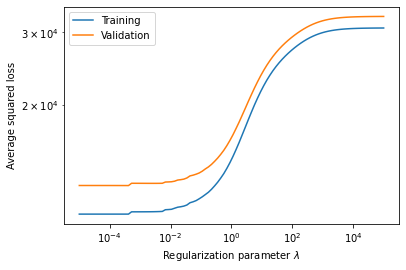

In [41]:
# Penalty / Regularization Factor (Lambda) Tuning for Ridge Regression (L2-Regression)

poly_reg = PolynomialFeatures (degree = 8)
x_poly = poly_reg.fit_transform(X_train)

lam = np.logspace(-5, 5, 100)

err_train_reg = []
err_test_reg = []

for l in lam:
    
    model_L2 = Ridge(alpha = l, normalize = True, solver = 'lsqr')
    model_L2.fit(x_poly, y_train)

    err_train_reg.append(((model_L2.predict(x_poly) - y_train)**2).mean())
    err_test_reg.append(((model_L2.predict(poly_reg.fit_transform(X_test)) - y_test)**2).mean())
    
plt.loglog(lam, err_train_reg, lam, err_test_reg)
plt.legend(["Training", "Validation"])
plt.xlabel("Regularization parameter $\lambda$")
plt.ylabel("Average squared loss")
# print(err_test_reg)

Text(0, 0.5, 'Average squared loss')

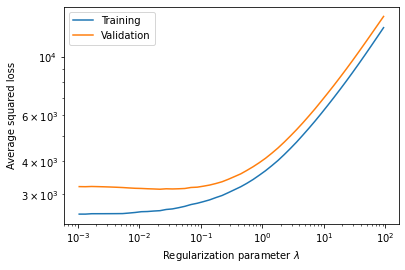

In [37]:
plt.loglog(lam[20:70], err_train_reg[20:70], lam[20:70], err_test_reg[20:70])
plt.legend(["Training", "Validation"])
plt.xlabel("Regularization parameter $\lambda$")
plt.ylabel("Average squared loss")

Lambda should be around 0.01 - 0.1 to minimize the Test Error.

### 4.4 Model Evaluation

TODO bla bla bla comparing features for models with hyperparameter analysed in prior model building 
- Decision Tree: Depth 11 
- Ridge Regression: 8th Degree
- XGBoost: default values

### Functions for Model Evaluation 

In [98]:
# function for Model Evaluation
def get_metrics(y_test, y_test_pred):
    print ('R²: ', r2_score(y_test, y_test_pred))
    print ('MAE: ', mean_absolute_error(y_test, y_test_pred))
    print ('RMSE: ', mean_squared_error(y_test, y_test_pred, squared = False), "\n")

In [93]:
# function for data splitting in test and training with specified set of features
def data_split(features):
    
    features.append('hourly_demand')
    features.append(features.pop(features.index('hourly_demand')))
    df = df_pred_feat[features]

    # split the data with 70% training data
    train, test = train_test_split(df, test_size = 0.3, random_state = 42)
    x_train = train.iloc[:,:-1]
    y_train = train.iloc[:,-1]

    x_test = test.iloc[:,:-1]
    y_test = test.iloc[:,-1]
    
    return x_train, y_train, x_test, y_test

In [70]:
# function to compare performance of regression models with different sets of features
def model_comparison(feature_list):
        
    storage = pd.DataFrame()
    
    poly_ridge = PolynomialFeatures (degree = 8)
    
    for n in range(len(feature_list)):

        x_train, y_train, x_test, y_test = data_split(feature_list[n])
        models=[Ridge(alpha = 0.01, normalize = True, solver = 'lsqr'), DecisionTreeRegressor(max_depth=11), xgb.XGBRegressor()]
        model_names=['Ridge (L2-) Regression', 'Decision Tree','XGBoost']
        

        x_ridge = poly_ridge.fit_transform(x_train)
        
        for model in range (len(models)):
            clf = models[model]
            
            if(model == 0):
                clf.fit(x_ridge, y_train)
                test_pred = clf.predict(poly_ridge.fit_transform(x_test))
            
            else:
                clf.fit(x_train,y_train)
                test_pred = clf.predict(x_test)
                
            r2 = (r2_score(y_test, test_pred))
            mae = (mean_absolute_error(y_test, test_pred))
            rmse = (mean_squared_error(y_test, test_pred, squared = False))
            
            storage = storage.append({'Features':str(n) + ' ' + str(feature_list[n]), 'Model':model_names[model], 'R²':r2}, ignore_index=True)

    return storage

### 4.4.1 Successively adding and evaluation performance of  basic features

In this structured approach the best set of features for each model will be determined. Hence features will be added successively to each model. For each model and set of features the R² is calculated. 

In [103]:
test_feature_row_1 = ['hour']
test_feature_row_2 = ['hour', 'month']
test_feature_row_3 = ['hour', 'month', 'weekday']
test_feature_row_4 = ['hour', 'month', 'weekday', 'precip']
test_feature_row_5 = ['hour', 'month', 'weekday', 'precip', 'temp_scaled']
test_feature_row_6 = ['hour', 'month', 'weekday', 'precip', 'temp_scaled', 'quarter_0', 'quarter_1', 'quarter_2', 'quarter_3']
test_feature_row_7 = ['hour', 'month', 'weekday', 'precip', 'temp_scaled', 'peak_hour_1', 'peak_hour_2']

featureList = [test_feature_row_1, test_feature_row_2, test_feature_row_3, test_feature_row_4, test_feature_row_5, test_feature_row_6, test_feature_row_7]

model_comp_grid = model_comparison(featureList)

model_comp_grid.pivot(index = 'Features', columns = 'Model')

R2  \
Model                                              Decision Tree   
Features                                                           
0 ['hour', 'hourly_demand']                             0.413519   
1 ['hour', 'month', 'hourly_demand']                    0.750183   
2 ['hour', 'month', 'weekday', 'hourly_demand']         0.848388   
3 ['hour', 'month', 'weekday', 'precip', 'hourl...      0.877312   
4 ['hour', 'month', 'weekday', 'precip', 'temp_...      0.879807   
5 ['hour', 'month', 'weekday', 'precip', 'temp_...      0.882975   
6 ['hour', 'month', 'weekday', 'precip', 'temp_...      0.881290   

                                                                                      \
Model                                              Ridge (L2-) Regression 8th Degree   
Features                                                                               
0 ['hour', 'hourly_demand']                                                 0.254832   
1 ['hour', 'month', 'hourly_demand']                                        0.528071   
2 ['hour', 'month', 'weekday', 'hourly_demand']                             0.550230   
3 ['hour', 'month', 'weekday', 'precip', 'hourl...                          0.563169   
4 ['hour', 'month', 'weekday', 'precip', 'temp_...                          0.602507   
5 ['hour', 'month', 'weekday', 'precip', 'temp_...                          0.612300   
6 ['hour', 'month', 'weekday', 'precip', 'temp_...                          0.628364   

                                                              
Model                                                XGBoost  
Features                                                      
0 ['hour', 'hourly_demand']                         0.413519  
1 ['hour', 'month', 'hourly_demand']                0.749583  
2 ['hour', 'month', 'weekday', 'hourly_demand']     0.848944  
3 ['hour', 'month', 'weekday', 'precip', 'hourl...  0.891457  
4 ['hour', 'month', 'weekday', 'precip', 'temp_...  0.922349  
5 ['hour', 'month', 'weekday', 'precip', 'temp_...  0.921748  
6 ['hour', 'month', 'weekday', 'precip', 'temp_...  0.920537

The results show that involving information about the season (quarter-dummys) and peak hours does not improve the models further. Therefore these features will not be included in upcoming feature set comparisons. 

### 4.4.2 Comparing performance of numeric weekday and boolean is_weekday features

In [72]:
test_feature_row_10 = ['hour', 'month', 'weekday', 'precip', 'temp_scaled']
test_feature_row_11 = ['hour', 'month', 'is_workday', 'precip', 'temp_scaled']
test_feature_row_12 = ['hour', 'month', 'weekday', 'is_workday', 'precip', 'temp_scaled']

featureList2 = [test_feature_row_10 , test_feature_row_11 , test_feature_row_12]

model_grid_weekday_comp = model_comparison(featureList2)

model_grid_weekday_comp.pivot(index = 'Features', columns = 'Model')

R2  \
Model                                              Decision Tree   
Features                                                           
0 ['hour', 'month', 'weekday', 'precip', 'temp_...      0.882270   
1 ['hour', 'month', 'is_workday', 'precip', 'te...      0.885964   
2 ['hour', 'month', 'weekday', 'is_workday', 'p...      0.879602   

                                                                                      \
Model                                              Ridge (L2-) Regression 8th Degree   
Features                                                                               
0 ['hour', 'month', 'weekday', 'precip', 'temp_...                          0.602507   
1 ['hour', 'month', 'is_workday', 'precip', 'te...                          0.606108   
2 ['hour', 'month', 'weekday', 'is_workday', 'p...                          0.605626   

                                                              
Model                                                XGBoost  
Features                                                      
0 ['hour', 'month', 'weekday', 'precip', 'temp_...  0.922349  
1 ['hour', 'month', 'is_workday', 'precip', 'te...  0.910502  
2 ['hour', 'month', 'weekday', 'is_workday', 'p...  0.922349

No relevant performance difference in using **is_weekday** and **weekday** is found. Therefore the numeric weekday as a feature will be used from now on. 

### 4.4.3 Comparing performance of cyclical presentation of hour and month 

In [95]:
test_feature_row_21 = ['hour_sin', 'hour_cos']
test_feature_row_22 = ['hour_sin', 'hour_cos', 'month_sin', 'month_cos']
test_feature_row_23 = ['hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'weekday']
test_feature_row_24 = ['hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'weekday', 'precip']
test_feature_row_25 = ['hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'weekday', 'precip', 'temp_scaled']

featureList_cyclical = [test_feature_row_21 , test_feature_row_22 , test_feature_row_23, test_feature_row_24, test_feature_row_25]

model_comp_grid_cyclical = model_comparison(featureList_cyclical)

model_comp_grid_cyclical.pivot(index = 'Features', columns = 'Model')

R2  \
Model                                              Decision Tree   
Features                                                           
0 ['hour_sin', 'hour_cos', 'hourly_demand']             0.413519   
1 ['hour_sin', 'hour_cos', 'month_sin', 'month_...      0.749661   
2 ['hour_sin', 'hour_cos', 'month_sin', 'month_...      0.826182   
3 ['hour_sin', 'hour_cos', 'month_sin', 'month_...      0.867214   
4 ['hour_sin', 'hour_cos', 'month_sin', 'month_...      0.868119   

                                                                                      \
Model                                              Ridge (L2-) Regression 8th Degree   
Features                                                                               
0 ['hour_sin', 'hour_cos', 'hourly_demand']                                 0.408335   
1 ['hour_sin', 'hour_cos', 'month_sin', 'month_...                          0.750250   
2 ['hour_sin', 'hour_cos', 'month_sin', 'month_...                          0.854971   
3 ['hour_sin', 'hour_cos', 'month_sin', 'month_...                          0.871825   
4 ['hour_sin', 'hour_cos', 'month_sin', 'month_...                          0.890254   

                                                              
Model                                                XGBoost  
Features                                                      
0 ['hour_sin', 'hour_cos', 'hourly_demand']         0.413519  
1 ['hour_sin', 'hour_cos', 'month_sin', 'month_...  0.749574  
2 ['hour_sin', 'hour_cos', 'month_sin', 'month_...  0.846507  
3 ['hour_sin', 'hour_cos', 'month_sin', 'month_...  0.887791  
4 ['hour_sin', 'hour_cos', 'month_sin', 'month_...  0.921135

Involving the cyclical presentation of hour and month considerably improves the performance of the Ridge Regression. The performance of the Decisison Tree and XGBoost model did not increase.

### 4.4.3 Model Evaluation Conclusion 

The model evaluation resulted in these feature sets with the corresponding R²:


**Decision Tree**: hour, month, weekday, precip, temp_scaled - **R²: 0.876**


**Ridge-Regression**: hour_sin, hour_cos, month_sin, month_cos, weekday, precip, temp_scaled - **R²: 0.890**


**XGBoost**: hour, month, weekday, precip, temp_scaled - **R²: 0.922**

For deplyment either the Ridge-Regression or the XGBoost model are suitable and either have their own advantages and drawbacks. 

**Ridge-Regression** is not that complex  and the model and its parameters are understandable in contrast to XGBoost, which is a black-box that can not be understood. 


However if model performance is the most relevant aspect, **XGBoost** performs better, which is a valid reason to choose it. 

## 4.5 Outlook

In this section further improvements are discussed and implemented. Furthermore suggestions for a follow-up project are given. 

### 4.5.1 Hyperparamter Tuning with Grid Search


While some hyperparamters in the models like the **polynomial degree for Ridge Regression** or the **Tree Depth for the Decision Tree** were already adjusted, there are more hyperparamters than can be tuned to improve the model performance. 

Using **Grid Search Cross Validation** different sets of hyperparamters can be fitted on compared on the models. In this section we only focus on hyperparamter tuning for the XGBoost model, as we expect  the biggest potential. 

In [82]:
# show the hyperparamters for the chosen models
models=[Ridge(), DecisionTreeRegressor(), xgb.XGBRegressor()]
model_names=['Ridge Regression', 'Decision Tree','XGBoost']

for model in range (len(models)):
    clf = models[model]
    print(model_names[model],": ")
    print(clf.get_params(), "\n")

Ridge Regression : 
{'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': 'deprecated', 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001} 

Decision Tree : 
{'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'} 

XGBoost : 
{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'enable_categorical': False, 'gamma': None, 'gpu_id': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_delta_step': None, 'max_depth': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': None,

In [104]:
# creating test and train data with best features for XGBoost
features_XGBoostCV =  ['hour', 'month', 'weekday', 'precip', 'temp_scaled']
x_train, y_train, x_test, y_test = data_split(features_XGBoostCV)

In [106]:
# XGBoost model with default hyperparamters for comparisson
model = xgb.XGBRegressor()
model.fit(x_train, y_train)
y_test_pred = model.predict(x_test)
get_metrics(y_test_pred, y_test)

R²:  0.9151016239483774
MAE:  29.031451159810345
RMSE:  50.44416018102407 



In [137]:
# creating set of hyperparamters
parameters = {
    'nthread':[4],
    'gamma': [0.5, 1.5, 3],
    'max_depth': [20, 30], 
    'n_estimators': [100, 200, 300 ,400],
    'learning_rate': [0.5, 0.3, 0.1]}

In [138]:
# grid search
tic = time.perf_counter()
    
model_gridsearch_cv = xgb.XGBRegressor()

xgb_grid = GridSearchCV(model_gridsearch_cv,
                        parameters,
                        cv = 4,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(x_train, y_train)

# result of the cv grid search
print('Best model hyperparamters: ', xgb_grid.best_params_)

y_test_pred_grid = xgb_grid.predict(x_test)

get_metrics(y_test_pred_grid, y_test)

toc = time.perf_counter()
print(f"Grid Search Computing took {toc - tic:0.4f} seconds")

Fitting 4 folds for each of 72 candidates, totalling 288 fits
Best model hyperparamters:  {'gamma': 3, 'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 100, 'nthread': 4}
R²:  0.8932925767519685
MAE:  29.78019801453975
RMSE:  56.85077816351629 

Grid Search Computing took 1169.9601 seconds


The Grid Search Cross Validation resulted in a worse performance than the default hyperparamters. By validating on more hyperparamters values the performance could propably perform better. As this is very intensive computing that takes long periods to calculate, we do not perform more Grid Search. 

### 4.5.2 Further possible improvements


- More features like windspeed, information about holidays, the spatial distribution of the bikes in the bikesharing area could be useful.


- One of the improvements still possible, is finding the optimal set of features for each model by trying every combination of features. The approach used in **4.4** helped choosing features but most propaby did not resolve in the optimal set of features. 


- Furthermore more advanved Machine Learning like the Auto-Sklearn Regression could be used to determine the 'optimal' prediction model. 